# Implemention of the behavior Pattern Method
nach 
Diamantini, C., Genga, L. & Potena, D. Behavioral process mining for unstructured processes. J Intell Inf Syst 47, 5–32 (2016). https://doi.org/10.1007/s10844-016-0394-7

In [1]:
import pm4py
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.obj import Event
from pm4py.objects.log.obj import Trace
import os
import json

## Import XES File
from https://pm4py.fit.fraunhofer.de/documentation#item-impoort-xes

Event Log, und Trace: 
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?  highlight=objects%20log%20obj%20eventlog#pm4py.objects.log.obj.EventLog

EventLog[] => Trace  
EventLog[][] => Event of Trace

#### Ist eine Bereiningung des Event Logs nötigt auf => Aktivitäten 
Der event Log zeigt die Events nicht die ausgeführten Aktivitäten, wirkt sich das aus auf die Generierung des Petri Net und Alignemt, weil die Events verwendet werden nicht die Aktivitäten.

In [2]:
from pm4py.objects.log.importer.xes import importer as xes_importer

In [3]:
path = "datasets/02_TestCompletedFFF_onlyTaskItems_simpleFilter.xes"
# path = "datasets/01_TestCompletedFFF_IDtoString_removeTransitionClassifier.xes"
log = xes_importer.apply(path)

parsing log, completed traces :: 100%|██████████| 81/81 [00:01<00:00, 63.74it/s]


BoxPLot, um Size Verteilung zu sehen und Ausreißer zu identifizieren.
Ziel dadurch das Modell zu vereinfachen und Zeit in dr Berechnung der Alignment zu sparen: 

Der BoxPLot zeigt anhand der Trace Sizes 2 Ausreißer an: >800 und >300


133.320987654321


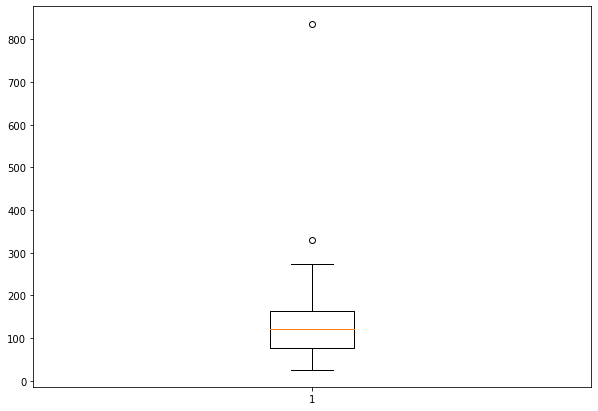

In [4]:
import matplotlib.pyplot as plt

# Creating dataset
data = list()
summe= 0
for trace in log:
    trace_len = len(trace)
    data.append(trace_len)
    summe += trace_len

print(summe/len(data))

fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

In [5]:
filtered_log = pm4py.filter_case_size(log, 0, 300) 
log = filtered_log
print(len(log))

79


In [ ]:
## print(len(log)) 
## type is trace, is also eine sequence
""" event = log[2][0]
print(event)
print(event['concept:name'])
 """

## Get Real Welt Modell as Petri Net 
with Inductive Miner Infrequent for Casual Relation  
from https://pm4py.fit.fraunhofer.de/documentation#item-3-2 

The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2

Dauer ca. 2min

In [6]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.objects.petri_net.importer import importer as pnml_importer


In [7]:
variantIM = inductive_miner.Variants.IMf
# Log
""" net, initial_marking, final_marking = inductive_miner.apply(log,variant=variantIM)
pnml_exporter.apply(net, initial_marking, "output/petri_net_full.pnml", final_marking=final_marking) """ 


# Log gefiltert
""" filtered_log = pm4py.filter_case_size(log, 0, 300)
net, initial_marking, final_marking = inductive_miner.apply(filtered_log,variant=variantIM)
pnml_exporter.apply(net, initial_marking, "output/petri_filtered.pnml", final_marking=final_marking)  """


' filtered_log = pm4py.filter_case_size(log, 0, 300)\nnet, initial_marking, final_marking = inductive_miner.apply(filtered_log,variant=variantIM)\npnml_exporter.apply(net, initial_marking, "output/petri_filtered.pnml", final_marking=final_marking)  '

### Import Petri Net

In [8]:
# Full Petri Net
## net, initial_marking, final_marking = pnml_importer.apply(os.path.join("output/petri_net_full.pnml"))

# Filtered Petri Net
net, initial_marking, final_marking = pnml_importer.apply(os.path.join("output/petri_filtered.pnml"))


In [103]:
# Print Einsicht PetriNet

""" place = net.places
print(place)
print(place.name)

arc = place.in_arcs[0]
print(arc.source.name, arc.source.label) """

places = net.places
for place in places:
    if place == final_marking or place == initial_marking:
      print('yes')

""" places = net.places
for place in places:
  print("\nPLACE: "+place.name)
  for arc in place.in_arcs:
    print(arc.source.name, arc.source.label) """

""" print(net.arcs)
print(net.places)
print(net.transitions) """
""" print(net.places)
print(net.transitions) """

""" for trans in net.transitions:
    print(trans.label, trans.name) """

## print(net.arcs[0].name)

' for trans in net.transitions:\n    print(trans.label, trans.name) '

## From Petri Netz zu Instance Ordering  

### Casual Relation:

Zwei events i, j haben eine Causal Relation, wenn i erst abgeschlossen werden muss, damit j ausgeführt werden kann.  
Das Petri Netz ist Modell und die CR Relation, bzw. die Grundlage davon. Mithilfe der Funktionen get PreCR und getPostCR from PetriNet Transition.

### Instance Ordering: 

i, j und k sind Events; i<k<j  
Es besteht eine CR Relation zwischen i und j;  
und  
(Es darf keine CR Relation zwischen i und k:  
Oder  
Es darf keine CR Relation zwischen k und j geben;)  

Bezug zum Petri Netz, welches als Grundlage für die CR Relation verwendet wird:  
Ein Event ist im Petri Netz eine Transition; der Aktivitäten Name kann über Label aufgerufen werden.

Siehe hierzu auch  
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.petri_net.html?highlight=petrinet#pm4py.objects.petri_net.obj.PetriNet  
https://pm4py.fit.fraunhofer.de/documentation#item-4-2

In [9]:
from pm4py.objects.petri_net.obj import PetriNet
import warnings


In [11]:
# Ist Transition in Trace
## Achtung eine Aktivität hat mehrere Events (start,, complete ect.), d.h. es tritt in trace mehrfach auf
## TODO: Eine Aktivität kann mehrfach auftreten, und von jemanden andern durchgeführt werden, wie behandeln wir diesen Fall? 
# Aktuell erscheine mehrfach auftretende Aktivitäten dadurch erscheinen, dass sie im Pnetz drin ist. Was unsere CR Grundlage ist.
# Das reicht aus, weil wir die Instance ordering nur auf Basis der CR bemessen. 
# die delted und inserted Aktivitäten bekommen wird bei der Reparatur aus. später heraus
# Sollen wir diese Fälle unterscheiden, indem wir den Namen und die 
for trans in net.transitions:
    transLabel = str(trans.label) # eventname der aktuellen iteration
    isTransInTrace = lambda event: transLabel == event['concept:name']
    filteredItems = list(filter(isTransInTrace , trace))
    # prüfe Aktivität im PNetz auftaucht; theoretisch unnötig Petri Netz aus eventlog generiert
    if(len(filteredItems)>0):
        print(transLabel + 'is Part of Trace')
    else:
        warnings.warn('Is Not Part of Trace: ' + transLabel)

G8 - 12: Coordinate/ensure change informationis Part of Trace
G7 - 5: Initiate APQP / PPAPis Part of Trace
Release Part / digital data task checkis Part of Trace
Review & Release Gate 6is Part of Trace
Status Changed Parts: Released for Productionis Part of Trace
Drawings released & Parts ready for engineeringis Part of Trace
Prepare Gate 9is Part of Trace
Prepare Gate 7 Releaseis Part of Trace
G8 - 8: Evaluate changes to production & supply chainis Part of Trace
G9 - 1: Complete  APQP/PPAPis Part of Trace
G8 - 7: QMA Check 2is Part of Trace
Reset to Newis Part of Trace
G8 - 2: Ensure use of technologies & standardsis Part of Trace
Check Part Roles, Docs & Parts to be changedis Part of Trace
Status Change EC: Engineering Releaseis Part of Trace
Review & Release Gate 8is Part of Trace
EC Responsible has rejectedis Part of Trace
Status Change EC: Executionis Part of Trace
G7 - 8: Impact on production/supplier & supply chainis Part of Trace
Status Change EC: Definitionis Part of Trace
G8 

C:\Users\alfer\AppData\Local\Temp/ipykernel_13932/3553362673.py:16: UserWarning: Is Not Part of Trace: None
  warnings.warn('Is Not Part of Trace: ' + transLabel)
C:\Users\alfer\AppData\Local\Temp/ipykernel_13932/3553362673.py:16: UserWarning: Is Not Part of Trace: Add new sources /Repeat approval tests
  warnings.warn('Is Not Part of Trace: ' + transLabel)
C:\Users\alfer\AppData\Local\Temp/ipykernel_13932/3553362673.py:16: UserWarning: Is Not Part of Trace: Ensure all parts are released for production
  warnings.warn('Is Not Part of Trace: ' + transLabel)
C:\Users\alfer\AppData\Local\Temp/ipykernel_13932/3553362673.py:16: UserWarning: Is Not Part of Trace: Approval relevance?
  warnings.warn('Is Not Part of Trace: ' + transLabel)
C:\Users\alfer\AppData\Local\Temp/ipykernel_13932/3553362673.py:16: UserWarning: Is Not Part of Trace: All parts in EC ready for production / supplier
  warnings.warn('Is Not Part of Trace: ' + transLabel)
C:\Users\alfer\AppData\Local\Temp/ipykernel_13932/355

In [110]:
def getOrderingTransitions(net):
    arcedTrans = list()
    # Transition == Event or activity
    places = net.places
    for place in places:
        for arc_in in place.in_arcs:
            for arc_out in place.out_arcs:
                arcedTrans.append((arc_in.source, arc_out.target))
    return arcedTrans

def getInstanceGraphEdges(net: PetriNet):
    InstanceOrdering = set()
    # get Casual Relation bzw instance Ordering Transitions: 
    # Instance Ordering Eigenschaft, da CR und keine CR dazwischen (laut Modell)!
    orderingList = getOrderingTransitions(net)
    # gehe über alle Transitionen mit ihren follower
    for ordering in orderingList:
        # get eventnamen über transition laben, nimm ransition name, wenn stille transition
        transitionLabel = ordering[0].label # eventname
        if transitionLabel == None:
            transitionLabel = ordering[0].name
        transitionFollowerLabel = ordering[1].label # eventname
        if transitionFollowerLabel == None:
            transitionFollowerLabel = ordering[0].name
        
        tuple = (transitionLabel, transitionFollowerLabel)
        InstanceOrdering.add(tuple)        

    return InstanceOrdering

## Instance Graphen

Werden aus dem Instance Ordering, welches  aus der vorangegangen Methode erhalten haben.
Es wird nun nach den Vorgaben aus den Wissenschaftlichen Beitrag ein Instanz Graph erstellt.  
Ein Instance Graph wird ein Tupel aus Knoten, edges und einen Dicht sein, welches ein Mapping zwischen dem den Knoten und dem entsprechenden Log Event darstellt.

Referenzen zum Event Log
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?highlight=eventlog#pm4py.objects.log.obj.EventLog



In [111]:
def genInstanceGraphInsEdgeBase(trace, instOrdering):
    """ Generates Nodes on Edge, in other words from Instace ordering Output """
    nodes = set()
    nodeEventDict = dict()
     # Kanten, aber nicht in Edge Form
    # for ordering in instOrdering
    # TODO: handle ressource, passe die kanten Benennung an die node Benennung an
    edges = instOrdering
    # Nodes
    for edge in edges:
        nodes.add(edge[0])
        nodes.add(edge[1])
    # Event Mapping
    for node in nodes:
        nodeEventDict[node] = list(filter(lambda event: event['concept:name'] == node, trace))
   
    return nodes, edges, nodeEventDict


In [112]:
instanceOrdering = getInstanceGraphEdges(net)
nodes, edges, nodeEventDict = genInstanceGraphInsEdgeBase(log[0],instanceOrdering)
instanceGraph0 = (nodes, edges, nodeEventDict)
labelTuple = ('nodes','edges','nodeEventDict')
""" for index in range(len(instanceGraph0)):
    print(labelTuple[index])
    print(instanceGraph0[index]) """

' for index in range(len(instanceGraph0)):\n    print(labelTuple[index])\n    print(instanceGraph0[index]) '

### Generiere alle Instanz Graphen

In [113]:
instanceOrdering = getInstanceGraphEdges(net)
instanceGraphs = list()
for instance in log:
    nodes, edges, nodeEventDict = genInstanceGraphInsEdgeBase(instance,instanceOrdering)
    instanceGraphs.append((nodes, edges, nodeEventDict))


### Bewertung verfahren (Fitness PetriNet)
Stand 04.01.22 Ansatz über Transitionen iterieren.  

113 von 439 Transitionen in 6576 Fällen werden von dem in den Traces nicht erfasst, also 25%.  
Hierzu sei angemerkt, dass 439 Transitionen im Petri Netz existieren. Insgesamt besitzt der Datensatz 181 Aktivitäten.  
Problem 1: Andere Aktivitäten sind nicht im Modell. Für diese lässt sich daher keine CR bestimmen.

108 Transitionen in 2729 Fällen kommen mehrfach in einen Trace. In so einem Fall, wird jedoch nur eine Casual Relation einmal hinzugefügt. Würde die Aktivität ein zweites mal im PetriNetz auftauchen werden die Relationen entsprechend ein weiteres mal auf Casual Relation untersucht.  
Probleme 2: Im Trace kommt kein zweites mal ein Event vor, jedoch im PetriNetz/Modell => es würde ein CR erstellt werden.


Lösung und warum so lassen, wie es ist: Aus CR Richtung, unterscheide mithilfe der Ressource(?); aus PetriNetz Richtung: sie sind als unterschiedliche Events durch den Transnamen identifiziert. jedoch erschwert sich eine Zuordnung.  
Erwäge erste For Schleife mit Trace zu belegen und 2 For Schleife mit Transitionen? Vermutlich kein Änderungen. wir müssten dann eine weitere For schleife haben, die über alle Transitionen iteriert, um die CR für alle zu erhalten. Wir könne schwer identifizieren, ob es sie um dieselbe Aktivitäten wie im Trace handelt. Das würde den Code sehr verkomplizieren. 
Können wir es so lassen wie es aktuell ist? - Dann sind alle CR aus dem Petri Nets abgebildet, aber doppelte vorkommen Aktivitäten/Transitionen im Model, werden als dieselbe bewertet, bsp. ABA.
Womöglich kein Problem.
Hier sind Korrekturen nötig

### Filter parallele Elemente  
ein Element ist parall, wenn es keine Predecessor und Successor, vgl. van der Aals 2004

(Wahrscheinlich Start oder Ende)  
Approval relevance?  
G8 - 1: Check Compatibility  (Indicator)  


97 Parallele Aktivitäten

In [18]:
nonSourceTransition = set(filter(lambda edge: edge[0]==None, instanceOrderingPost))
nonTargetTransition = set(filter(lambda edge: edge[1]==None, instanceOrderingPost))

parallelActivities = set()
for trans in nonSourceTransition:
    try:
        parallelActivities.add(next(x[0] for x in nonTargetTransition if x[0] == trans[1]))
    except StopIteration:
        print(trans[1] + ': Nope')
print(str(len(parallelActivities))+ ' Parallele Aktivitäten')

G8 - 1: Check Compatibility  (Indicator): Nope
Approval relevance?: Nope
97 Parallele Aktivitäten


### Visualisierung Instance Graphen ohne Reperatur


Bibliothek NetworkX Data Struktur

https://networkx.org/documentation/stable/tutorial.html

https://networkx.org/documentation/stable/reference/classes/digraph.html

https://www.youtube.com/watch?v=xREnpVUbkFI 

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

#### FIXED Erkenne None Tranistionen als Hidden Transistionen
Transitionen mit None sind hidden Transitions, Start und End (oder parallele )Transitionen.

Verbesserung: Im Rahen der Instance Graphen Generierung berücksichtigen! 
Unterscheidung nach  
skip?  
hidden Transition  
start und end => skip bei node check

<strong>Fixed</strong> indem bei CR nicht mehr der label verwendet wurde sondern der name der Transition!


In [20]:
endNode = 'Inserted Endnode'
startNode = 'Inserted StartNode'
unbekannt = 'unbekannt'
def replaceNoneEdges(edge):
    if(edge[0]==None):
        return (startNode, edge[1])
    elif edge[1]==None:
        return (edge[0], endNode)
    elif (edge[1]==None and edge[0]==None):
        print('Eine Unbekannte Kante')
        return (unbekannt, unbekannt)
    return edge



def drawInstanceGraph(nodes, edges, nodeEventDict, isFiltered: bool, filename=''):
    G = nx.DiGraph() # empty Graph
    if (isFiltered):
        edges = filter(lambda edge: edge[0]!=None and edge[1]!=None ,edges) # entferne alle Kante mit None
    else: 
        edges = list(map(replaceNoneEdges ,edges)) # replace with Start and Ende
    #G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    # G.add_edges_from([('A','B'), ('A','C'), ('C','B'), ('B','C')])
    
    # pos = nx.multipartite_layout(G) ## layers of straight lines: https://networkx.org/documentation/stable/reference/drawing.html?highlight=layout#module-networkx.drawing.layout)
    # zwo straight lines
    #top = nx.bipartite.sets(G)[0]
    ##pos = nx.bipartite_layout(G, top) 
    pos = nx.spring_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=1000)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowsize=1, node_size=1000, width=5)
    nx.draw_networkx_edge_labels(G, pos)

    plt.rcParams['figure.figsize'] = [100, 40] # Größe
    ## plt.show()
    plt.savefig('./output/'+filename+'.png')
    plt.close()

In [21]:
""" i = 0
for iGraph in instanceGraphs:
    drawInstanceGraph(iGraph[0], iGraph[1], iGraph[2], False, 'i_graphs/trace_'+str(i))
    i+=1 """

" i = 0\nfor iGraph in instanceGraphs:\n    drawInstanceGraph(iGraph[0], iGraph[1], iGraph[2], False, 'i_graphs/trace_'+str(i))\n    i+=1 "

### Viele nebenläufige Kanten 
Bei einer Stichprobe von Instanz Graphen kommen eine überwiegende Menge an Knoten Vorschein, deren Instanz Graphen viele Knoten besitzen, die nicht mit dem Graph verbunden sind. vgl. Trace 0.
Diese auszuschneiden bringt einen recht übersichtlichen Graphen, aber kleine Graphen mehr als 3/4 der Knoten fehlen.  
Ein Austausch der None Knoten an Position 0 (1) durch einen Startknoten (Endknoten) zu ersetzen fügt sie wieder ein, bringt aber zum Vorschein, dass dieser Fall überwiegt.  
Vergleich nebenläufige Transition bzw in CR

## Repair irreguläre Instanz Graphen 

### Fitness based Conformance Algorithmus in PM4Py:
https://pm4py.fit.fraunhofer.de/documentation#item-5-1

<strong>trace_is_fit</strong>: boolean value (True/False) that is true when the trace is according to the model.  
=> if true ignore, if false find Anomalie Positions

<strong>activated_transitions</strong>: list of transitions activated in the model by the token-based replay.  
=> use to remove all Transitions, which work => inserted 

<strong>reached_marking</strong>: marking reached at the end of the replay  
=> Position of total destruction???

Disgnostics: https://pm4py.fit.fraunhofer.de/documentation#item-5-1-1
Throughput analysis on the transitions that are executed in an unfit way according to the process model (the Petri net).
Throughput analysis on the activities that are not contained in the model.

place_fitness: Conformance aus Sicht der Places

trans_fitness: Conformance aus Sicht der Transistioen 

unwanted_activities: "<em>containing activities that are not in the model</em>,"   
=> Annahme der Durchschnitt zwischen traces and unwanted_Activities entspricht <strong>deleted Activities</strong>

<strong>Verwerfe diese betrachtung und nutze lieber das Aligment von PM4Py. </strong>



In [22]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay


In [23]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}
replayed_traces, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(log, net,
                                                                                              initial_marking,
                                                                                              final_marking,
                                                                                              parameters=parameters_tbr)

replaying log with TBR, completed variants :: 100%|██████████| 79/79 [00:49<00:00,  1.59it/s]


### PM4Py Alignment: Kosten der Abweichen benutzen zum aufspüren irregulärer Traces
https://pm4py.fit.fraunhofer.de/documentation#item-5-2

Spüren mithilfe der aligmentn Kosten auf ob deletet oder inserted. Nach Definiion.

Docs: https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.algo.conformance.alignments.petri_net.html#pm4py.algo.conformance.alignments.petri_net.algorithm.apply_log

Alignment zu berechnen dauert lange in Jupyter: bis zu 30h

Source: S. 105 & 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).

JSON from here https://www.geeksforgeeks.org/read-write-and-parse-json-using-python/?ref=lbp

In [24]:
transList = list()
for trans in net.transitions:
    if (trans.label == None):
        transList.append(trans)
print(len(transList))

226


Alignment Berechnung in kleine Teile aufgespalten:

In [26]:
def openAlignment(filename):
    f = open('alignment/output/'+filename+'.json','r')
    al_t = json.load(f)
    f.close()
    return al_t

Mapping Alignment to traces

In [45]:
filtered_log_0 = pm4py.filter_case_size(log, 0, 70)
filtered_log_70 = pm4py.filter_case_size(log, 71, 100)
filtered_log_100 = pm4py.filter_case_size(log, 101, 130)
filtered_log_130 = pm4py.filter_case_size(log, 131, 150)
filtered_log_150 = pm4py.filter_case_size(log, 151, 180)
filtered_log_180 = pm4py.filter_case_size(log, 181, 220)
filtered_log_220 = pm4py.filter_case_size(log, 221, 300)

filtered_logs = (filtered_log_0, filtered_log_70, filtered_log_100, filtered_log_130, filtered_log_150, filtered_log_180, filtered_log_220)
fileindexes = (0,70,100,130,150,180,220)

def getAlignmentLogMapping(filtered_logs, fileindexes):
    alignmentLogMapping = dict()
    """ on 0 is alignment log list 
        on 1 is log """
    for i in range(len(fileindexes)):
        logOfFile = filtered_logs[i]
        filename = 'aligned_traces_'+str(fileindexes[i])
        alignmentList = openAlignment(filename)

        if(len(logOfFile)!=len(alignmentList)):
            print('aligned list sind ungleich lang: ' + str(filename))
        else:
            for index in range(len(logOfFile)):
                variantStr = logOfFile[index].attributes['variant']
                alignment = alignmentList[index]
                alignmentLogMapping[variantStr] = alignment
    return alignmentLogMapping

def getTracePerVariant(log: EventLog, variant:str):
    for trace in log:
        if trace.attributes['variant']==variant:
            return trace


def printAlignment(alignmentLogMapping: dict, log = None):
    for key, item in alignmentLogMapping.items():
            print(key)
            if log != None:
                getTracePerVariant(log, key)
            print(item)
            print("__________________________________________________________________________")

In [47]:
alignmentLogMapping = getAlignmentLogMapping(filtered_logs, fileindexes)

## print all Alignments
printAlignment(alignmentLogMapping)

## print all Alignments with her trace
## printAlignment(alignmentLogMapping, log)

Variant 14
{'alignment': [['>>', None], ['>>', None], ['>>', None], ['Product Modification Responsible is correctly assigned?', 'Product Modification Responsible is correctly assigned?'], ['>>', None], ['Product Modification Responsible is correctly assigned?', 'Product Modification Responsible is correctly assigned?'], ['>>', None], ['>>', None], ['Check Part Roles, Docs & Parts to be changed', 'Check Part Roles, Docs & Parts to be changed'], ['>>', None], ['>>', None], ['>>', None], ['Reset to New', 'Reset to New'], ['>>', None], ['Reset to New', 'Reset to New'], ['>>', None], ['>>', None], ['>>', None], ['EC Responsible has rejected', 'EC Responsible has rejected'], ['>>', None], ['>>', None], ['>>', None], ['Check Part Roles, Docs & Parts to be changed', 'Check Part Roles, Docs & Parts to be changed'], ['>>', None], ['>>', None], ['>>', None], ['>>', None], ['Continue to Evaluation', 'Continue to Evaluation'], ['>>', None], ['Continue to Evaluation', 'Continue to Evaluation'], ['>>


### Alignment
* Sync move: the classification of the event corresponds to the transition label; in this case, both the trace and the model advance in the same way during the replay.
+ Move on log: for couples where the second element is », it corresponds to a replay move in the trace that is not mimicked in the model. This kind of move is unfit and signal a deviation between the trace and the model.
* Move on model: for couples where the first element is », it corresponds to a replay move in the model that is not mimicked in the trace. For moves on model, we can have the following distinction:
  * Moves on model involving hidden transitions: in this case, even if it is not a sync move, the move is fit.
  * Moves on model not involving hidden transitions: in this case, the move is unfit and signals a deviation between the trace and the model.
  
from https://pm4py.fit.fraunhofer.de/documentation#item-5-2

### Irregulare Traces / Move in the Model
Irregular Traces are Move in the Models. In such a way it is described in  
S. 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).

TODO: Unterscheide Hidden Transitions!


In [59]:
def sortMoveInTheModel(alignment):
    modelMoves = list()
    for x in alignment:
        if (x[0]=='>>'):
            modelMoves.append(x)
    return modelMoves

def genMoveInTheModelAll(alignmentVariantDict: dict):
    moveInTheModelAll = dict()
    ## key ist varianten name und alignmentList sind die 
    for key, alignment in alignmentVariantDict.items():
        if(alignment != None):
            moveInThemodel = sortMoveInTheModel(alignment['alignment'])
            moveInTheModelAll[key] = moveInThemodel
        else: 
            print('Non Alignment Detected! With key: ' + key)
    return moveInTheModelAll


In [69]:
alignmentLogMapping = getAlignmentLogMapping(filtered_logs, fileindexes)
moveInTheModelAll = genMoveInTheModelAll(alignmentLogMapping)
for key, item in moveInTheModelAll.items():
    lenAlign = len(alignmentLogMapping[key]['alignment'])
    lenMoves = len(item)
    anteil = lenMoves / lenAlign
    print(key + ' irregular Traces Anteil: ' + str(anteil))
    print('moves:' + str(lenMoves))
    print('alignments: '+ str(lenAlign))


Variant 14 irregular Traces Anteil: 0.6111111111111112
moves:99
alignments: 162
Variant 18 irregular Traces Anteil: 0.6666666666666666
moves:98
alignments: 147
Variant 30 irregular Traces Anteil: 0.5783132530120482
moves:96
alignments: 166
Variant 39 irregular Traces Anteil: 0.7142857142857143
moves:65
alignments: 91
Variant 44 irregular Traces Anteil: 0.65
moves:104
alignments: 160
Variant 46 irregular Traces Anteil: 0.6481481481481481
moves:105
alignments: 162
Variant 48 irregular Traces Anteil: 0.6130952380952381
moves:103
alignments: 168
Variant 56 irregular Traces Anteil: 0.6415094339622641
moves:102
alignments: 159
Variant 58 irregular Traces Anteil: 0.6424242424242425
moves:106
alignments: 165
Variant 62 irregular Traces Anteil: 0.6272189349112426
moves:106
alignments: 169
Variant 71 irregular Traces Anteil: 0.6459627329192547
moves:104
alignments: 161
Variant 72 irregular Traces Anteil: 0.6407185628742516
moves:107
alignments: 167
Variant 74 irregular Traces Anteil: 0.622950819

In [ ]:
from alignment_custom_cost.custom_cost_function import getCostFunctionParameter
def getIA(moveInTheModelTrace, trace):



In [46]:



rep_trace = replayed_traces[0]
real_trace = log[0]
if(rep_trace.trace_is_fit):
    getIAundDA(rep_trace, real_trace)
    
def checkTraceConformace(trace, aligned_trace, petriNet):
    cost = aligned_trace['cost']
    alignment = aligned_trace['alignment']
    if():
    deletedActivities = set()
    insertedActivities = set()
    # sind inactivated transistions deleted transistions?
    return deletedActivities, insertedActivities

SyntaxError: invalid syntax (Temp/ipykernel_17580/356909845.py, line 2)

In [21]:
def deletionRepair(edges, event, CR):
    return edges

def insertionRepair(edges, event, CR, trace):
    return edges

def repairInstanceGraph(instanceGraph, trace, DA,IA, CR ):
    edges = instanceGraph[1]
    for event in DA:
        edges = deletionRepair(edges, event, CR)
    for event in IA:
        edges = insertionRepair(edges, event, CR, trace)
    return (instanceGraph[0], edges, instanceGraph[2])

        

SyntaxError: invalid syntax (Temp/ipykernel_17580/1219825961.py, line 9)

In [ ]:
for index in range(len(replayed_traces)):
    rep_trace = replayed_traces[index]
    real_trace = log[index]
    if(rep_trace.trace_is_fit):
        getIAundDA(rep_trace, real_trace)

### Visualisierung Instance Graphen


Bibliothek NetworkX Data Struktur

https://networkx.org/documentation/stable/tutorial.html

https://networkx.org/documentation/stable/reference/classes/digraph.html

https://www.youtube.com/watch?v=xREnpVUbkFI

In [86]:
import networkx as nx
import matplotlib.pyplot as plt

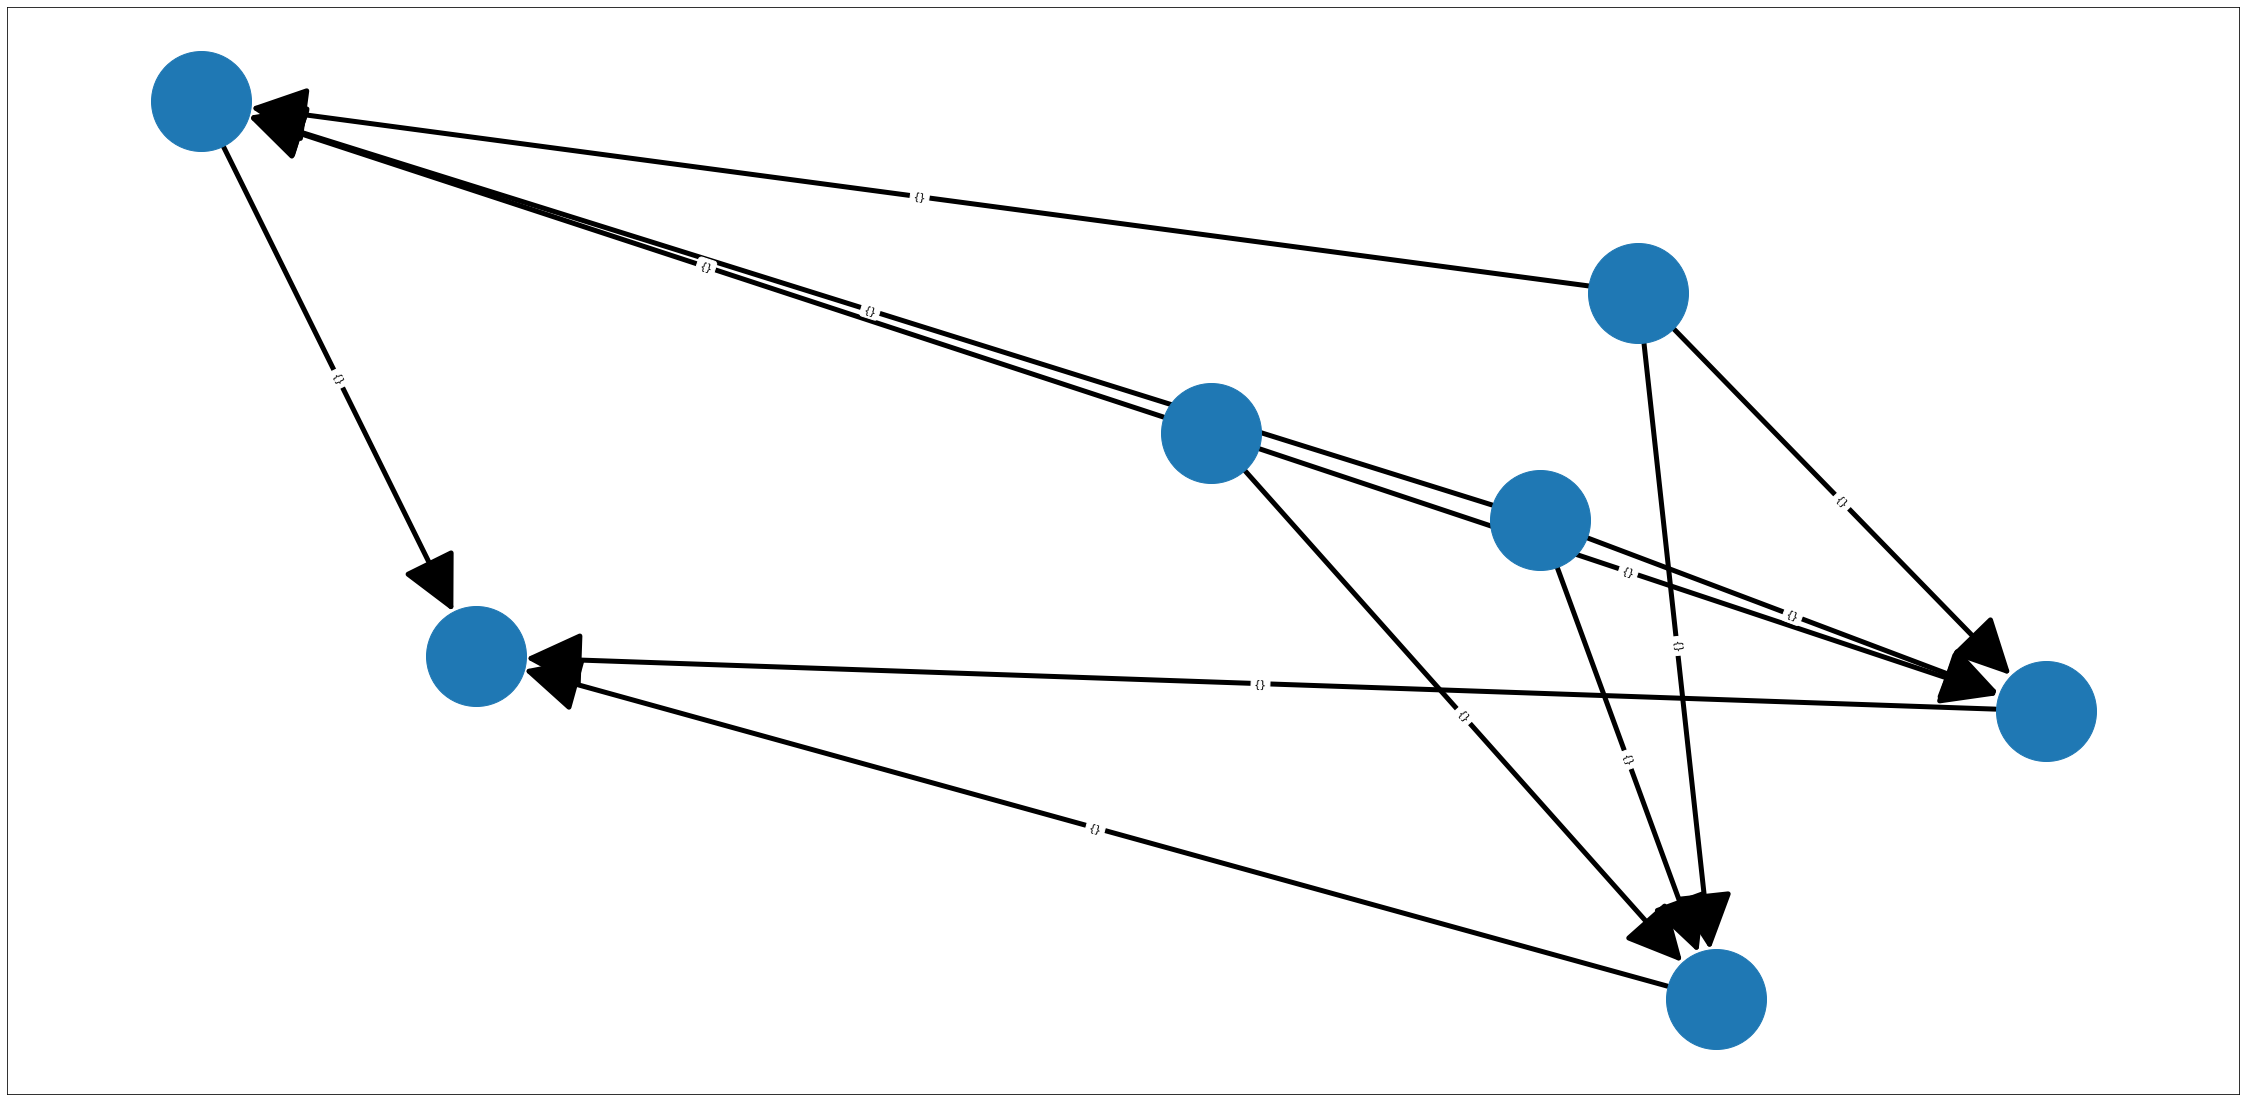

## Substructure Evaluation

Kapitel 5.2.1 Substructures evaluation

diversity,
completeness (coverage of the model),
Repräsentativität,
Häufigkeit (substrukturen),